#### Зимняя школа CompTech
# Прогноз спроса и планирование рабочих смен

## Подзадача 2.
- В зависимости от того, сколько будет в i-ый час заказов, рассчитать, сколько надо курьеров
- Оптимальное количество курьеров: delay rate < 5%

### Подход - константа

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# загрузка данных
data_orders = pd.read_csv('/Users/margaritamelnikova/Documents/00_learning/2022_WinterSchool/comptech_team_1/data/orders.csv', parse_dates=['date'])
data_partners = pd.read_csv('/Users/margaritamelnikova/Documents/00_learning/2022_WinterSchool/comptech_team_1/data/partners_delays.csv', parse_dates=['dttm'])

# глобальная переменная - delay rate < 5%
delay_threshold = 0.05

# подготовка датафрейма
data_orders.columns = ['delivery_area_id', 'dttm', 'orders_cnt']
df = pd.merge(data_orders, data_partners, on=['dttm', 'delivery_area_id'], how='inner')
df['date'] = df['dttm'].dt.date
df['order_p_partner'] = df['orders_cnt'] / df['partners_cnt']
df['delay'] = np.where(df['delay_rate'] < delay_threshold, 0, 1)
df['orders_cnt_delayed'] = df['orders_cnt'] * df['delay_rate']

df.head(2)

,delivery_area_id,dttm,orders_cnt,partners_cnt,delay_rate,date,order_p_partner,delay,orders_cnt_delayed
0,0,2021-04-01 10:00:00,9,4.0,0.111111,2021-04-01,2.25,1,1.0
1,0,2021-04-01 11:00:00,1,4.0,0.000000,2021-04-01,0.25,0,0.0


#### Находим глабальное значение доли опозданий для каждой delivery area
Гипотеза: нужно взять для расчета константы только те delivery area, где глобальное значение опозданий ниже установленной границы в 5%.

380


count    593.000000
mean       0.047286
std        0.016635
min        0.017442
25%        0.035758
50%        0.044612
75%        0.056736
max        0.120906
Name: global_delay_share, dtype: float64

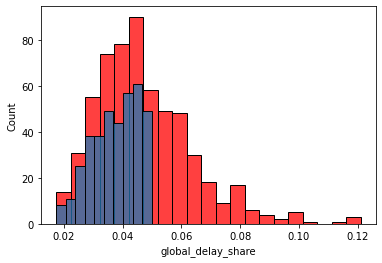

In [2]:
df_delays = df.groupby('delivery_area_id')[['orders_cnt', 'orders_cnt_delayed']].sum()
df_delays['global_delay_share'] = df_delays['orders_cnt_delayed'] / df_delays['orders_cnt']

# сохраняем delivery_area_id, где global_delay_share < threshold
delivery_area_good_stat = list(df_delays[df_delays['global_delay_share'] < delay_threshold].index)
print(len(delivery_area_good_stat))

# строим гистограммы распределения для всей выборки delivery_area_id и для global_delay_share < threshold
sns.histplot(data=df_delays, x='global_delay_share', color='r')
sns.histplot(data=df_delays[df_delays.index.isin(delivery_area_good_stat)], x='global_delay_share')
df_delays['global_delay_share'].describe()

count    884856.000000
mean          1.500624
std           0.579608
min           0.052632
25%           1.000000
50%           1.500000
75%           2.000000
max           3.142857
Name: order_p_partner, dtype: float64

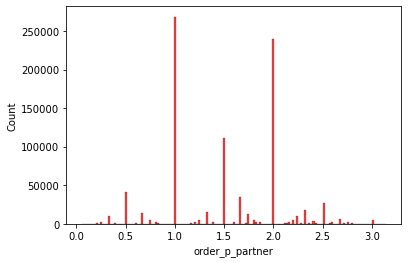

In [3]:
sns.histplot(data=df, x='order_p_partner', color='r')
df['order_p_partner'].describe()

<AxesSubplot:xlabel='order_p_partner'>

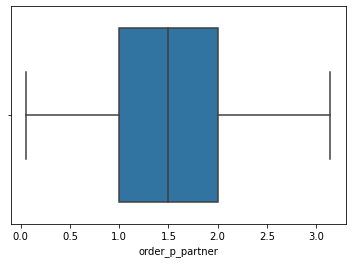

In [4]:
sns.boxplot(data=df, x='order_p_partner')

count    456533.000000
mean          1.360715
std           0.521496
min           0.052632
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: order_p_partner, dtype: float64

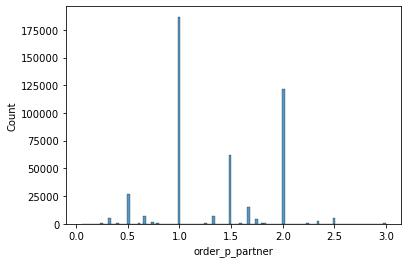

In [5]:
sns.histplot(data=df[df['delivery_area_id'].isin(delivery_area_good_stat)], x='order_p_partner')
df[df['delivery_area_id'].isin(delivery_area_good_stat)]['order_p_partner'].describe()

<AxesSubplot:xlabel='order_p_partner'>

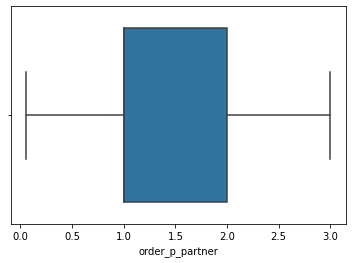

In [6]:
sns.boxplot(data=df[df['delivery_area_id'].isin(delivery_area_good_stat)], x='order_p_partner')

По распределению order_p_partner делаем вывод, что можно взять все наблюдения для расчета

#### Находим количество партнеров в расчете на заказ
В основу расчета положим бутстрап для тех наблюдений, где локальный delay rate ниже нашего трешхолда.

In [7]:
def get_bootstrap_ci(df, num_experiments=1000, alpha=0.05):
    '''
    Функция считает доверительный интервал (двусторонний) при помощи бутстрэпа.
    ---
    Параметры:
        df               -- датафрейм
        num_experiments  -- количество экспериментов в симуляции
        alpha            -- уровень значимости  
    
    '''
    # формируем выборку CTR
    mean_data = []
    for i in range(num_experiments):
        sample = df.sample(frac=0.5, replace=True)
        mean = sample.mean()
        mean_data.append(mean)
    
    # рассчитываем границы доварительного интервала
    ci = np.percentile(mean_data, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    median = np.percentile(mean_data, 0.5)
    return ci, median

# устанавливаем уровень значимости
alpha=0.05

In [8]:
# рассчитываем доверительный интервал - фильтр на уровне самого датасета (опоздания < трешхолд)
ci, median = get_bootstrap_ci(
    df[df['delay_rate'] < delay_threshold]['order_p_partner'], num_experiments=1000, alpha=alpha)
low, high = ci[0], ci[1]
message_ci = f'{(1-alpha):.2f} доверительный интервал составляет [{low:.3f}; {high:.3f}]'
message_median = f'Расчетное значение коэффициента равно {median:.3f}'
print(message_ci)
print(message_median)

0.95 доверительный интервал составляет [1.403; 1.407]
Расчетное значение коэффициента равно 1.403
